In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import keras
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras import layers as kl
from tensorflow.keras import losses
from tensorflow.keras import optimizers


os.chdir(os.getcwd().replace("/notebooks", "") if os.getcwd().startswith("/Users") else "/content/drive/MyDrive/Colab Notebooks/image_duplicate")

from src.models.euclidian_distance import euclidian_distance
from src.data.dataset import loader as dataset_loader
from src.visualisations.image_plot import plot_n
from src.data.dataset.image_shape import ImageShape
from src.data.utility.tf_data_transformer import TfDatasetTransformer

%load_ext autoreload
%autoreload 2

# Config

In [2]:
DATASET_LOADER = dataset_loader
IMAGE_SHAPE = ImageShape(height=224, width=224, depth=3)

BATCH_SIZE = 64

# Data Loading

In [3]:
train_dataset = DATASET_LOADER.load_train_v1()
val_dataset = DATASET_LOADER.load_validation_v1()

In [4]:
pair_tuples = list(map(lambda pair: (pair.image_a, pair.image_b, pair.similar), train_dataset.image_pairs))
pair_array = np.array(pair_tuples)


tf_dataset_transformer =  TfDatasetTransformer(image_shape=IMAGE_SHAPE)

train_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(train_dataset, shuffle=True, shuffle_buffer_size=1024)\
                                         .cache()\
                                         .batch(BATCH_SIZE)\
                                         .prefetch(AUTOTUNE)

val_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(val_dataset)\
                                         .cache()\
                                         .batch(128)\
                                         .prefetch(AUTOTUNE)


2022-03-01 21:50:09.997942: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
v = next(train_tf_dataset.as_numpy_iterator())[0][0][0]
v

2022-03-01 20:03:30.991536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

# Model

In [5]:
def create_common_model() -> keras.Model:
    input = keras.Input(shape=IMAGE_SHAPE.to_shape())
    x = kl.Conv2D(filters=64, kernel_size=7, strides=2, padding="valid", activation="relu")(input)
    x = kl.MaxPool2D(pool_size=3)(x)
    x = kl.Flatten()(x)
    return keras.Model(inputs=input, outputs=x)

def create_model() -> keras.Model:
    input_a = keras.Input(shape=IMAGE_SHAPE.to_shape())
    input_b = keras.Input(shape=IMAGE_SHAPE.to_shape())

    common_model = create_common_model()

    layer_a = common_model(input_a)
    layer_b = common_model(input_b)

    merge_layer = kl.Lambda(euclidian_distance)([layer_a, layer_b])
    merge_layer = kl.Dense(128)(merge_layer)
    merge_layer = kl.Dense(1, activation="sigmoid")(merge_layer)

    return keras.Model(inputs=[input_a, input_b], outputs=merge_layer)



model = create_model()
model.compile(
    optimizer=optimizers.Adam(), loss=losses.CategoricalHinge(), metrics="accuracy")

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 82944)        9472        ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

Epoch 1/3
726/726 [==============================] - 1040s 1s/step - loss: 0.6595 - accuracy: 0.8490 - val_loss: 0.6973 - val_accuracy: 0.7821
Epoch 2/3
726/726 [==============================] - 586s 806ms/step - loss: 0.6030 - accuracy: 0.8718 - val_loss: 0.7012 - val_accuracy: 0.7687
Epoch 3/3
726/726 [==============================] - 651s 895ms/step - loss: 0.5976 - accuracy: 0.8729 - val_loss: 0.6883 - val_accuracy: 0.7806


<AxesSubplot:>

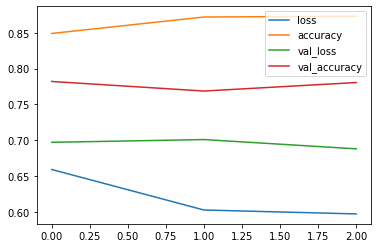

In [6]:
history = model.fit(train_tf_dataset, epochs=3, workers=8, max_queue_size=20, validation_data=val_tf_dataset)

pd.DataFrame(history.history).plot()

In [17]:
import gc
gc.collect(2)#%%


6296